In [1]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import random
import os
import dendropy
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

Using backend: pytorch


In [19]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.weight = glorot_init(in_feats,out_feats)
    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)
class GraphConvSparse(nn.Module):
    def __init__(self,in_dim,out_dim,activation):
        super(GraphConvSparse, self).__init__()
        self.layer1 = GCNLayer(in_dim, out_dim)
        self.activation = activation
    def forward(self, features, g):
        x = self.activation(self.layer1(g, features))
        return x
def glorot_init(input_dim, output_dim):
	init_range = np.sqrt(6.0/(input_dim + output_dim))
	initial = th.rand(input_dim, output_dim)*2*init_range - init_range
	return nn.Parameter(initial)

In [29]:
class VGAE(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim):
        super(VGAE,self).__init__()
        self.base_gcn = GraphConvSparse(input_dim, hidden1_dim, F.relu)
        self.gcn_mean = GraphConvSparse(hidden1_dim, hidden2_dim, lambda x : x)
        self.gcn_logstddev = GraphConvSparse(hidden1_dim, hidden2_dim, lambda x : x)
        self.hidden2_dim = hidden2_dim
    def encode(self, X, tree):
        hidden = self.base_gcn(X,tree)
        self.mean = self.gcn_mean(hidden,tree)/500
        self.logstd = self.gcn_logstddev(hidden,tree)/500
        gaussian_noise = th.randn(X.size(0), self.hidden2_dim)
        sampled_z = gaussian_noise*th.exp(self.logstd) + self.mean
        return sampled_z

    def forward(self, X,tree):
        Z = self.encode(X,tree)
        A_pred = dot_product_decode(Z)
        return A_pred
def dot_product_decode(Z):
	A_pred = th.sigmoid(th.matmul(Z,Z.t()))
	return A_pred

def glorot_init(input_dim, output_dim):
	init_range = np.sqrt(6.0/(input_dim + output_dim))
	initial = th.rand(input_dim, output_dim)*2*init_range - init_range
	return nn.Parameter(initial)

In [4]:
def load_features():
    fileDir = os.path.dirname(os.path.realpath('__file__'))
    """
    all_features is nxdxc tensor, n is the number of gene trees in the dataset, 
    d is the number of nodes in each tree and c is the length of the initial feature
    """
    all_features= th.ones((3997,72,1499))
    #all_features = th.ones((50,72,1499))
    cur = 0
    for i in range(4000):
    #for i in range(50):
        if(i==327 or i==3061 or i==3306):continue
        #tmp = '/home/qikaiy2/gene_512/data/ASTRAL_1_sim/condition1/alignment/tree'+str(i)+'.terms.embed'
        tmp='ASTRAL_1_sim/condition1/alignment/tree'+str(i)+'.terms.embed'
        filename = os.path.join(fileDir, tmp)
        feature_f = open(filename,"r")
        features=[]
        line = feature_f.readline()
        no = 0
        while line != '':
            if(no==0):
                no+=1
                continue
            line = feature_f.readline()
            no+=1
            l = line.split('\t')
            if(len(l)==1): break
            feature = l[1]
            feature = feature.split(' ')
            feature = feature[1:]
            feature[len(feature)-1] = feature[len(feature)-1][0]
            for j in range(len(feature)):
                feature[j] = int(feature[j])
            features.append(feature)
        feature_f.close()
        features = th.FloatTensor(features)
        
        all_features[cur] = features
        cur += 1
    return all_features
all_features = load_features()
print(all_features.size())

torch.Size([3997, 72, 1499])


In [5]:
def load_masks():
    """
    train,test mask contains the indexes of the trees served 
    as training data or test data, respectively
    """
    idx = []
    for i in range(3997):
        idx.append(i)
    train_mask,test_mask,_,_ = train_test_split(idx, idx, test_size=0.33, random_state=42)
    return train_mask, test_mask

In [6]:
def load_gene_trees(): 
    fileDir = os.path.dirname(os.path.realpath('__file__'))
    """
    G is a list of dgl graphs of length n, each graph is a dgl representation of the 
    input trees
    """
    G = []
    for i in range(4000):
        if(i==327 or i==3061 or i==3306):continue
        tmp = 'ASTRAL_1_sim/condition1/tree/tree'+str(i)+'.taxo'
        filename = os.path.join(fileDir, tmp)
        feature_f = open(filename,"r")
        line = feature_f.readline()
        nodes1=[]
        nodes2=[]
        dic_temp = {}
        relation = []
        i = 37
        while line != '':
            if(int(line.split()[0].replace(" ", "")) > 100):
                if (int(line.split()[0].replace(" ", "")) not in dic_temp):
                    dic_temp[int(line.split()[0].replace(" ", ""))] = i
                    i += 1
            else:
                dic_temp[int(line.split()[0].replace(" ", ""))] = int(line.split()[0].replace(" ", "")) - 1
            if(int(line.split()[1].replace("\n", "")) > 100):
                if (int(line.split()[1].replace("\n", "")) not in dic_temp):
                    dic_temp[int(line.split()[1].replace("\n", ""))] = i
                    i += 1
            else:
                dic_temp[int(line.split()[1].replace("\n", ""))] = int(int(line.split()[1].replace("\n", ""))) - 1
            relation.append((int(line.split()[0].replace(" ", "")), \
                             int(line.split()[1].replace("\n", ""))))
            relation.append((int(line.split()[1].replace("\n", "")), \
                             int(line.split()[0].replace(" ", ""))))
            line = feature_f.readline()
        g = dgl.DGLGraph()
        for item in relation:
            g.add_edges(dic_temp[item[0]], dic_temp[item[1]])
            g.add_edges(dic_temp[item[1]], dic_temp[item[0]])
        G.append(g)
    return G
geneTrees = load_gene_trees()
print("loaded " + str(len(geneTrees)) + " gene trees")

/opt/anaconda3/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


loaded 3997 gene trees


In [10]:
import time
import numpy as np

In [8]:
def check_root(node):
    if(node.parent_node == None):
        return True
    return False

def load_species_tree():
    """
    Output: g, a dgl graph representing the correct species tree with 37 (leaf) nodes 
    """
    ### load dictonary first
    dict_term = {}
    fileDir = os.path.dirname(os.path.realpath('__file__'))
    #tmp = '/home/qikaiy2/gene_512/data/ASTRAL_1_sim/condition1/term/tree0.terms'
    tmp = 'ASTRAL_1_sim/condition1/term/tree0.terms'
    filename = os.path.join(fileDir, tmp)
    term_file = open(filename,"r")
    for line in term_file.readlines():
        dict_term[line.split()[1]] = str(int(line.split()[0])-1)    
    #tmp = '/home/qikaiy2/gene_512/data/ASTRAL_1_sim/model-species-tree'
    tmp = 'ASTRAL_1_sim/model-species-tree'
    filename = os.path.join(fileDir, tmp)
    ### load species tree
    tree = dendropy.Tree.get(path=filename, schema="newick")
    leaf_nodes = [nd for nd in tree.leaf_node_iter()]
    i = len(leaf_nodes)
    
    ### preprocess the tree
    count = 0
    for nd in tree.postorder_node_iter():
        if check_root(nd) == False: # not root of the tree
            if nd.taxon == None: # internal node
                nd.taxon = dendropy.datamodel.taxonmodel.Taxon(str(i))
                i += 1
            else:
                nd.taxon = dendropy.datamodel.taxonmodel.Taxon(dict_term[nd.taxon.label])
            count += 1
            
    ### get the dgl graph
    remove_root = []
    result = dgl.DGLGraph()
    result.add_nodes(count)
    for nd in tree.postorder_node_iter():
        if check_root(nd) == False:
            if check_root(nd.parent_node) == True:
                remove_root.append(int(nd.taxon.label))
            else:
                result.add_edge(int(nd.taxon.label), int(nd.parent_node.taxon.label))
                result.add_edge(int(nd.parent_node.taxon.label), int(nd.taxon.label))
    result.add_edge(remove_root[0], remove_root[1])
    result.add_edge(remove_root[1], remove_root[0])
    return result

/opt/anaconda3/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


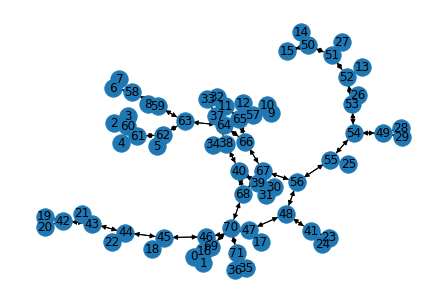

In [9]:
species_tree = load_species_tree()
nx.draw(species_tree.to_networkx(), with_labels=True)

In [33]:
def normalize(vector):
    min_v = th.min(vector)
    range_v = th.max(vector) - min_v
    normalised = (vector - min_v) / range_v
    return normalised

In [40]:
del model
model = VGAE(1499,256,72)
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
#scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.8, last_epoch=-1)
a = species_tree.to_networkx()
b = nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(a)
speciesMatrix = th.tensor(b[0:37, 0:37],dtype=th.float32)
speciesMatrix = normalize(speciesMatrix)
for epoch in range(100):
    loss_total = 0
    for tree in range(3997):
        pred = model(all_features[tree], geneTrees[tree])
        pred = pred[0:37, 0:37]
        pred = normalize(pred)
        try:
            loss = F.binary_cross_entropy(pred,speciesMatrix)
        except RuntimeError:
            print(th.min(pred))
            print(th.max(pred))
        logvar = th.pow(model.logstd,2)
        meanSquare = th.pow(model.mean,2)
        exp = logvar.exp()
        kl_divergence = 0.5/pred.size(0) * (1 + 2*model.logstd - meanSquare - exp).sum(1).mean()
        loss -= kl_divergence
        loss_total += loss
    loss_total /= 3997
    optimizer.zero_grad()
    print(loss_total)
    loss_total.backward()
    optimizer.step()
   # scheduler.step()

tensor(6.9440, grad_fn=<DivBackward0>)
tensor(6.5682, grad_fn=<DivBackward0>)
tensor(6.2889, grad_fn=<DivBackward0>)
tensor(6.0934, grad_fn=<DivBackward0>)
tensor(6.0109, grad_fn=<DivBackward0>)
tensor(5.9744, grad_fn=<DivBackward0>)
tensor(5.9646, grad_fn=<DivBackward0>)
tensor(5.9682, grad_fn=<DivBackward0>)
tensor(5.9876, grad_fn=<DivBackward0>)
tensor(6.0055, grad_fn=<DivBackward0>)
tensor(6.0142, grad_fn=<DivBackward0>)
tensor(6.0209, grad_fn=<DivBackward0>)
tensor(6.0201, grad_fn=<DivBackward0>)
tensor(6.0170, grad_fn=<DivBackward0>)
tensor(6.0097, grad_fn=<DivBackward0>)
tensor(5.9966, grad_fn=<DivBackward0>)
tensor(5.9857, grad_fn=<DivBackward0>)
tensor(5.9742, grad_fn=<DivBackward0>)
tensor(5.9714, grad_fn=<DivBackward0>)
tensor(5.9744, grad_fn=<DivBackward0>)
tensor(5.9767, grad_fn=<DivBackward0>)
tensor(5.9764, grad_fn=<DivBackward0>)
tensor(5.9735, grad_fn=<DivBackward0>)
tensor(5.9756, grad_fn=<DivBackward0>)
tensor(5.9777, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [24]:
"""
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

optimizerNet = th.optim.SGD(net.parameters(), lr=1e-1)
optimizerVAE = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss(reduction='sum')
dur = []
train_loss = []
validation_loss = []
#get correctMatrix
for epoch in range(100):
    print("pass")
    train_mask, test_mask = load_masks()
    n_trees= np.shape(train_mask)[0] #n_trees is the number of trees taking part in training
    speciesFeatures = th.ones(37, n_trees, 7)#37 species, each gene tree produces an embedding of length 7
    if epoch >=3:
        t0 = time.time()
    net.train()
    VAE.train()
    for i in range (n_trees):
        tree = geneTrees[train_mask[i]]
        features = all_features[train_mask[i]]
        genes = net(tree, features)
        genes =  genes[:37]
        speciesFeatures[:,i,:]=genes
    speciesFeatures = speciesFeatures.view(37,n_trees*7)
    speciesFeatures.retain_grad()
    reconstruction, mu, logvar = VAE(speciesFeatures)
    bce_loss = criterion(reconstruction, correctMatrix)
    loss = final_loss(bce_loss, mu, logvar)
    loss.backward()
    optimizerNet.step()
    optimizerVAE.step()
    Input = []
    Target = []
    Vec = []
    for qn in range(37):
        hot, vec = get_vectors_and_labels(qn, speciesFeatures)
        for search in range(len(hot)):
            if(hot[search] == 1):
                label = search
                break
        Target.append(label)
        Vec.append(vec)
    Target_tensor = th.tensor(Target)
    n=len(Vec)
    c=len(Vec[0])
    d=Vec[0][0].size()[0]
    Vec_tensor = th.zeros(n,c,d)
    for i in range(n):
        for j in range(c):
            Vec_tensor[i][j]=Vec[i][j]
    n = speciesFeatures.size()[0]
    c = speciesFeatures.size()[1]
    repeated = speciesFeatures.view(n,1,c)
    repeated = speciesFeatures.repeat(69, 1, 1)
    repeated = repeated.view(Vec_tensor.size())
    distances = th.linalg.norm(repeated-Vec_tensor,dim=2)
    logits = th.nn.functional.softmax(distances,1)
    l = th.nn.CrossEntropyLoss()
    loss = l(logits, Target_tensor)
    optimizer.zero_grad()
    loss.retain_grad()
    loss.backward()
    optimizer.step()
    
    #test
    with th.no_grad():
        n_tests= np.shape(test_mask)[0] 
        testFeatures = th.ones(37, n_tests, 7)
        for i in range (n_tests):
            tree = geneTrees[test_mask[i]]
            features = all_features[test_mask[i]]
            genes = net(tree, features)
            genes =  genes[:37]
            testFeatures[:,i,:]=genes
        testFeatures = testFeatures.view(37, n_tests*7)
        Input = []
        Target = []
        Vec = []
        for qn in range(37):
            hot, vec = get_vectors_and_labels(qn, testFeatures)
            for search in range(len(hot)):
                if(hot[search] == 1):
                    label = search
                    break
            Target.append(label)
            Vec.append(vec)
        Target_tensor = th.tensor(Target)
        n=len(Vec)
        c=len(Vec[0])
        d=Vec[0][0].size()[0]
        Vec_tensor = th.zeros(n,c,d)
        for i in range(n):
            for j in range(c):
                Vec_tensor[i][j]=Vec[i][j]
        n = testFeatures.size()[0]
        c = testFeatures.size()[1]
        repeated = testFeatures.view(n,1,c)
        repeated = testFeatures.repeat(69, 1, 1)
        repeated = repeated.view(Vec_tensor.size())
        distances = th.linalg.norm(repeated-Vec_tensor,dim=2)
        logits = th.nn.functional.softmax(distances,1)
        l = th.nn.CrossEntropyLoss()
        test_loss = l(logits, Target_tensor)
        
        
    if epoch >=3:
        dur.append(time.time() - t0)
    train_loss.append(loss)
    validation_loss.append(test_loss)
    print("Epoch {:05d} | Train Loss {:.4f} | Validation Loss {:.4f} | Time(s) {:.4f}".format(
            epoch, loss, test_loss, np.mean(dur)))
    #writer.writerow([epoch, loss, test_loss])
    """

pass
torch.Size([37, 18739])
